<a href="https://www.kaggle.com/code/saeedghadiri/lightgbm-lasso-feature-selection-top-5?scriptVersionId=93471647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import and load data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
import sklearn.metrics as skm
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.linear_model import Lasso

random_seed = 12345
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

sns.set_style('dark')

TRAIN_PATH = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
TEST_PATH = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
df = pd.read_csv(TRAIN_PATH) # load data
df_test = pd.read_csv(TEST_PATH) # load data
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,Gas

# Target Engineering

Let's take a look at the target

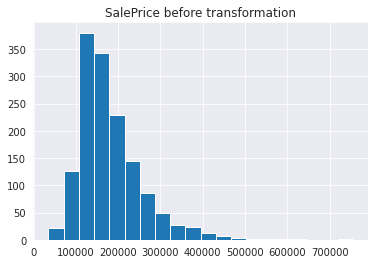

In [3]:
TARGET = 'SalePrice'

plt.figure()
df[TARGET].hist(bins=20)
plt.title(TARGET + ' before transformation')
plt.show()

As you can see, because of the high skewness and outliers, we need to log transform the target and delete some outliers by z-score.

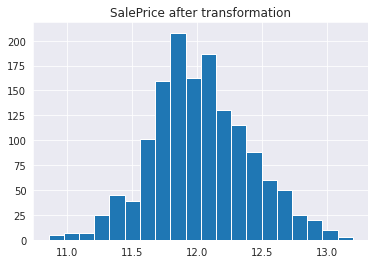

In [4]:
df[TARGET] = np.log(df[TARGET])
df['z_score_target'] = np.abs(stats.zscore(df[TARGET]))
df = df.loc[df['z_score_target'] < 3].reset_index(drop=True)
del df['z_score_target']

plt.figure()
df[TARGET].hist(bins=20)
plt.title(TARGET + ' after transformation')
plt.show()

# Feature Engineering

As a first step, we categorize features into three groups:
* Categorical: these features are disceret and contain limited number of categories and there is no order among categories.
* Nominal: these features are similar to categorical features but there is order between them. for instance **GarageCars** feature, which is the number of cars that the garage supports, is nominal.
* Numerical: these are features that are continous.

Among all the features, **GarageYrBlt** is excluded from the list because it has too many nan values that cannot be handled by assigning a meaningful number and there is not much information in it, since it is usually equal to YearBuilt.

In [5]:

NOMINAL_FEATURES = ["BedroomAbvGr", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                    "BsmtFullBath", "BsmtHalfBath", "BsmtQual", "ExterCond", "ExterQual",
                    "Fireplaces", "FireplaceQu", "Functional", "FullBath", "GarageCars",
                    "GarageCond", "GarageQual", "HalfBath", "HeatingQC", "KitchenAbvGr",
                    "KitchenQual", "LandSlope", "LotShape", "PavedDrive", "PoolQC",
                    "Street", "Utilities", "OverallCond", "OverallQual", "TotRmsAbvGrd"]


CATEGORICAL_FEATURES = ["Alley", 'MSSubClass', 'MoSold', 'MSZoning', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2',
                        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
                        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                        'Heating', 'CentralAir', 'Electrical', 'GarageType',
                        'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

NUMERICAL_FEATURES = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF','1stFlrSF',
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF',
                      'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
                      'MiscVal', 'YrSold'] # GarageYrBlt is deleted because of too many nan values


NUM_FEATURES = NOMINAL_FEATURES + NUMERICAL_FEATURES
ALL_FEATURES = NOMINAL_FEATURES + NUMERICAL_FEATURES + CATEGORICAL_FEATURES

df = df[ALL_FEATURES + [TARGET]].copy()

## Fix missing values

In [6]:
def fix_missing(df_data):
        # Handle missing values for features where median/mean or most common value doesn't make sense

    # Alley : data description says NA means "no alley access"
    df_data.loc[:, "Alley"] = df_data.loc[:, "Alley"].fillna("None")
    # BedroomAbvGr : NA most likely means 0
    df_data.loc[:, "BedroomAbvGr"] = df_data.loc[:, "BedroomAbvGr"].fillna(0)
    # BsmtQual etc : data description says NA for basement features is "no basement"
    df_data.loc[:, "BsmtQual"] = df_data.loc[:, "BsmtQual"].fillna("No")
    df_data.loc[:, "BsmtCond"] = df_data.loc[:, "BsmtCond"].fillna("No")
    df_data.loc[:, "BsmtExposure"] = df_data.loc[:, "BsmtExposure"].fillna("No")
    df_data.loc[:, "BsmtFinType1"] = df_data.loc[:, "BsmtFinType1"].fillna("No")
    df_data.loc[:, "BsmtFinType2"] = df_data.loc[:, "BsmtFinType2"].fillna("No")
    df_data.loc[:, "BsmtFullBath"] = df_data.loc[:, "BsmtFullBath"].fillna(0)
    df_data.loc[:, "BsmtHalfBath"] = df_data.loc[:, "BsmtHalfBath"].fillna(0)
    df_data.loc[:, "BsmtUnfSF"] = df_data.loc[:, "BsmtUnfSF"].fillna(0)
    df_data.loc[:, "TotalBsmtSF"] = df_data.loc[:, "TotalBsmtSF"].fillna(0)
    df_data.loc[:, "BsmtFinSF1"] = df_data.loc[:, "BsmtFinSF1"].fillna(0)
    df_data.loc[:, "BsmtFinSF2"] = df_data.loc[:, "BsmtFinSF2"].fillna(0)
    # CentralAir : NA most likely means No
    df_data.loc[:, "CentralAir"] = df_data.loc[:, "CentralAir"].fillna("N")
    # Condition : NA most likely means Normal
    df_data.loc[:, "Condition1"] = df_data.loc[:, "Condition1"].fillna("Norm")
    df_data.loc[:, "Condition2"] = df_data.loc[:, "Condition2"].fillna("Norm")
    # EnclosedPorch : NA most likely means no enclosed porch
    df_data.loc[:, "EnclosedPorch"] = df_data.loc[:, "EnclosedPorch"].fillna(0)
    # External stuff : NA most likely means average
    df_data.loc[:, "ExterCond"] = df_data.loc[:, "ExterCond"].fillna("TA")
    df_data.loc[:, "ExterQual"] = df_data.loc[:, "ExterQual"].fillna("TA")
    # Fence : data description says NA means "no fence"
    df_data.loc[:, "Fence"] = df_data.loc[:, "Fence"].fillna("No")
    # FireplaceQu : data description says NA means "no fireplace"
    df_data.loc[:, "FireplaceQu"] = df_data.loc[:, "FireplaceQu"].fillna("No")
    df_data.loc[:, "Fireplaces"] = df_data.loc[:, "Fireplaces"].fillna(0)
    # Functional : data description says NA means typical
    df_data.loc[:, "Functional"] = df_data.loc[:, "Functional"].fillna("Typ")
    # GarageType etc : data description says NA for garage features is "no garage"
    df_data.loc[:, "GarageType"] = df_data.loc[:, "GarageType"].fillna("No")
    df_data.loc[:, "GarageFinish"] = df_data.loc[:, "GarageFinish"].fillna("No")
    df_data.loc[:, "GarageQual"] = df_data.loc[:, "GarageQual"].fillna("No")
    df_data.loc[:, "GarageCond"] = df_data.loc[:, "GarageCond"].fillna("No")
    df_data.loc[:, "GarageArea"] = df_data.loc[:, "GarageArea"].fillna(0)
    df_data.loc[:, "GarageCars"] = df_data.loc[:, "GarageCars"].fillna(0)
    # HalfBath : NA most likely means no half baths above grade
    df_data.loc[:, "HalfBath"] = df_data.loc[:, "HalfBath"].fillna(0)
    # HeatingQC : NA most likely means typical
    df_data.loc[:, "HeatingQC"] = df_data.loc[:, "HeatingQC"].fillna("TA")
    # KitchenAbvGr : NA most likely means 0
    df_data.loc[:, "KitchenAbvGr"] = df_data.loc[:, "KitchenAbvGr"].fillna(0)
    # KitchenQual : NA most likely means typical
    df_data.loc[:, "KitchenQual"] = df_data.loc[:, "KitchenQual"].fillna("TA")
    # LotFrontage : NA most likely means no lot frontage
    df_data.loc[:, "LotFrontage"] = df_data.loc[:, "LotFrontage"].fillna(0)
    # LotShape : NA most likely means regular
    df_data.loc[:, "LotShape"] = df_data.loc[:, "LotShape"].fillna("Reg")
    # MasVnrType : NA most likely means no veneer
    df_data.loc[:, "MasVnrType"] = df_data.loc[:, "MasVnrType"].fillna("None")
    # KitchenAbvGr : NA most likely means 0
    df_data.loc[:, "MasVnrArea"] = df_data.loc[:, "MasVnrArea"].fillna(0)
    # MiscFeature : data description says NA means "no misc feature"
    df_data.loc[:, "MiscFeature"] = df_data.loc[:, "MiscFeature"].fillna("No")
    df_data.loc[:, "MiscVal"] = df_data.loc[:, "MiscVal"].fillna(0)
    # OpenPorchSF : NA most likely means no open porch
    df_data.loc[:, "OpenPorchSF"] = df_data.loc[:, "OpenPorchSF"].fillna(0)
    # PavedDrive : NA most likely means not paved
    df_data.loc[:, "PavedDrive"] = df_data.loc[:, "PavedDrive"].fillna("N")
    # PoolQC : data description says NA means "no pool"
    df_data.loc[:, "PoolQC"] = df_data.loc[:, "PoolQC"].fillna("No")
    df_data.loc[:, "PoolArea"] = df_data.loc[:, "PoolArea"].fillna(0)
    # SaleCondition : NA most likely means normal sale
    df_data.loc[:, "SaleCondition"] = df_data.loc[:, "SaleCondition"].fillna("Normal")
    # ScreenPorch : NA most likely means no screen porch
    df_data.loc[:, "ScreenPorch"] = df_data.loc[:, "ScreenPorch"].fillna(0)
    # TotRmsAbvGrd : NA most likely means 0
    df_data.loc[:, "TotRmsAbvGrd"] = df_data.loc[:, "TotRmsAbvGrd"].fillna(0)
    # Utilities : NA most likely means all public utilities
    df_data.loc[:, "Utilities"] = df_data.loc[:, "Utilities"].fillna("AllPub")
    # WoodDeckSF : NA most likely means no wood deck
    df_data.loc[:, "WoodDeckSF"] = df_data.loc[:, "WoodDeckSF"].fillna(0)
    return df_data

df = fix_missing(df.copy())
df_test = fix_missing(df_test.copy()) # apply to test data as well

## Categorical features

In [7]:
def fix_categories(df_data):

    # Some numerical features are actually really categories
    df_data = df_data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40",
                                               45 : "SC45", 50 : "SC50", 60 : "SC60",
                                               70 : "SC70", 75 : "SC75", 80 : "SC80",
                                               85 : "SC85", 90 : "SC90", 120 : "SC120",
                                               150 : "SC150", 160 : "SC160", 180 : "SC180",
                                               190 : "SC190"},
                               "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr",
                                           5 : "May", 6 : "Jun",7 : "Jul", 8 : "Aug", 9 : "Sep",
                                           10 : "Oct", 11 : "Nov", 12 : "Dec"}})
    
    
    # Encode some categorical features as ordered numbers when there is information in the order
    df_data = df_data.replace({"BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3,
                                             "Gd" : 4, "Ex" : 5},
                               "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                               "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3,
                                                 "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                               "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3,
                                                 "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                               "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4,
                                             "Ex" : 5},
                               "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                               "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                               "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3,
                                                "Gd" : 4, "Ex" : 5},
                               "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4,
                                               "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
                               "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3,
                                               "Gd" : 4, "Ex" : 5},
                               "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3,
                                               "Gd" : 4, "Ex" : 5},
                               "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4,
                                              "Ex" : 5},
                               "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4,
                                                "Ex" : 5},
                               "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                               "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                               "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                               "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3,
                                           "Ex" : 4},
                               "Street" : {"Grvl" : 1, "Pave" : 2},
                               "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3,
                                              "AllPub" : 4}}
                             )
    
    return df_data


df = fix_categories(df.copy())
df_test = fix_categories(df_test.copy()) # apply to test data as well

In this step, when a category is rare, which means it is present in fewer than 2% of the data, we combine it with other rare ones. Therefore, data has fewer rare categories, which makes learning process easier.

In [8]:
# combine rare categorical features
for col in CATEGORICAL_FEATURES:
    temp = df.groupby(col)[TARGET].count() / len(df)
    temp = temp[temp<0.02].index
    
    df[col] = np.where(df[col].isin(temp),'rare',df[col])
    df_test[col] = np.where(df_test[col].isin(temp),'rare',df_test[col]) # apply to test data as well

Convert category names to numbers so that algorithms can use them. we also have to support missing for all categorical features, because test data has missing values that never occured in some features in train data.

In [9]:
for feature in CATEGORICAL_FEATURES:
    labels_ordered = list(df.groupby([feature])['SalePrice'].mean().sort_values().index)
    if 'missing' not in labels_ordered:
        labels_ordered.append('missing')
    labels_ordered = {k:i for i,k in enumerate(labels_ordered,0)}
    df[feature] = df[feature].map(labels_ordered)
    
    df_test[feature] = df_test[feature].map(labels_ordered)

## Numerical Features

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

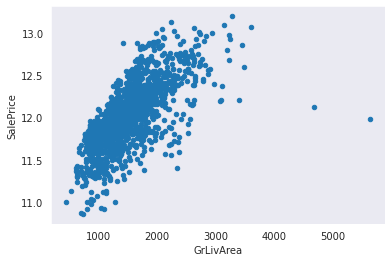

In [10]:
df.plot.scatter(x='GrLivArea', y=TARGET)

Samples with GrLivArea bigger than 4000 are obviously outliers, so we should delete them from our training dataset

In [11]:
df = df[df['GrLivArea'] < 4000].reset_index(drop=True)

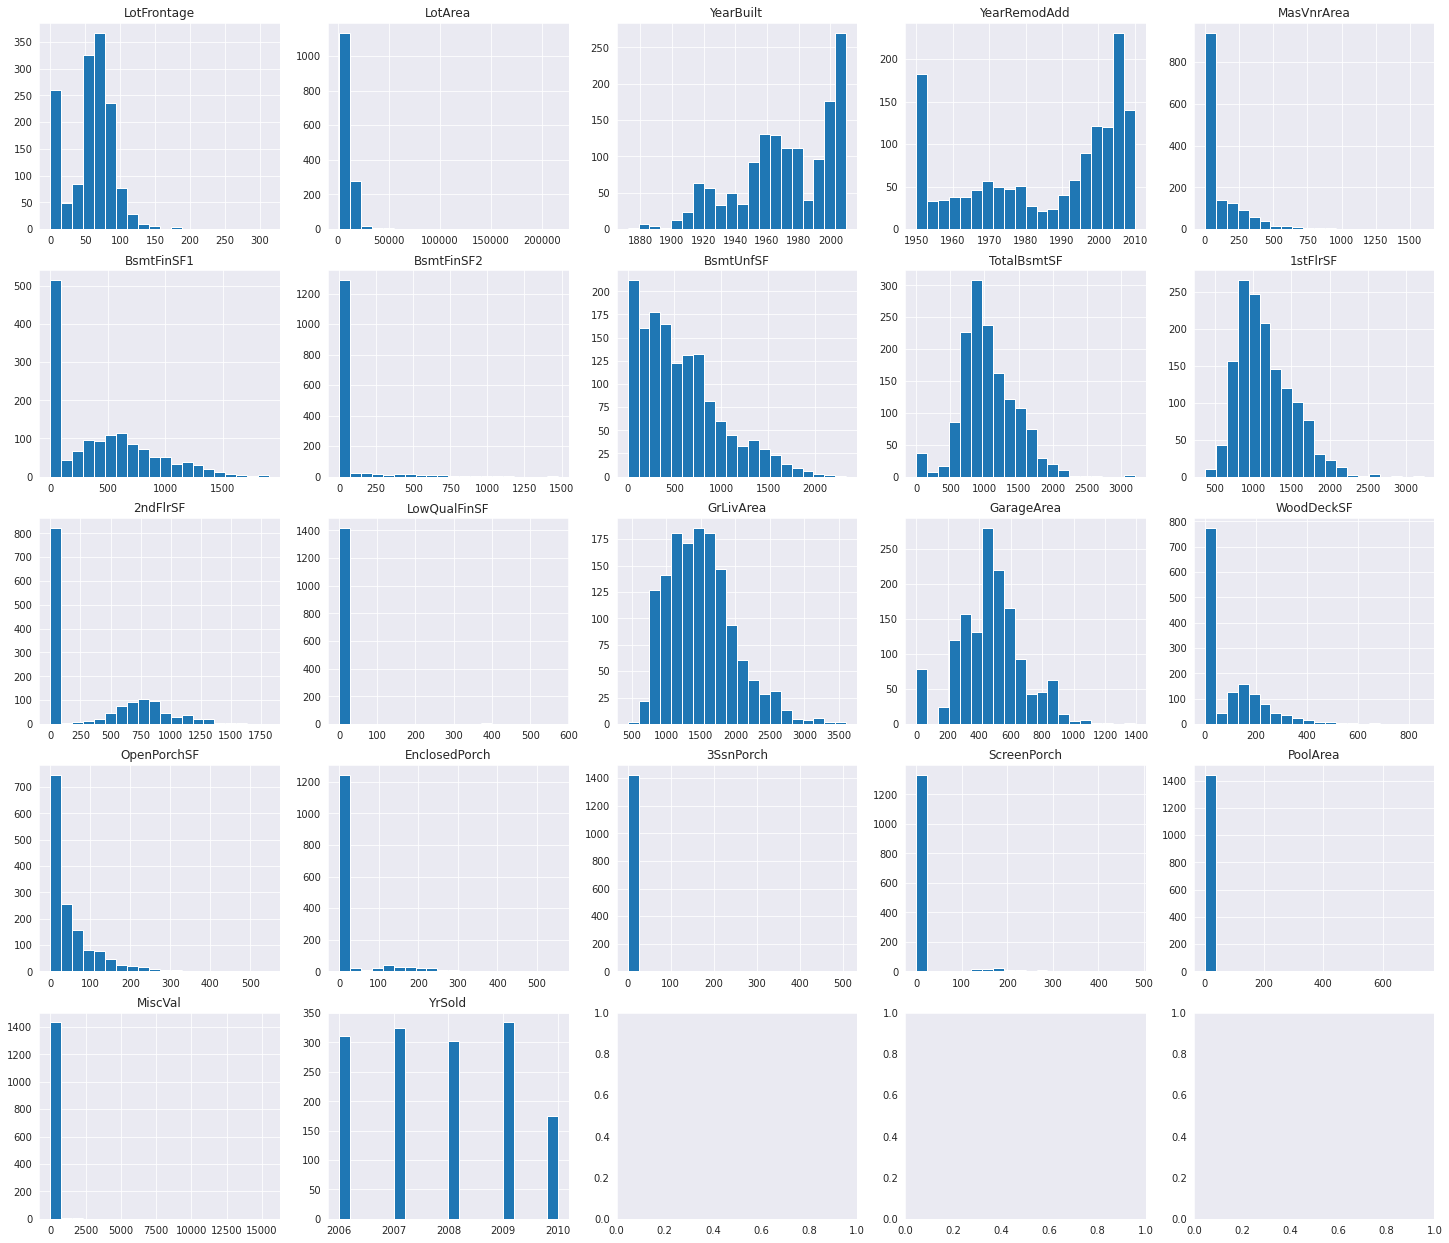

In [12]:
fig, ax = plt.subplots(int(np.ceil(len(NUMERICAL_FEATURES)/5)), 5, figsize=(25, len(NUMERICAL_FEATURES)))
for i, col in enumerate(NUMERICAL_FEATURES):
    df[col].hist(bins=20, ax= ax[i // 5, i % 5])
    ax[i // 5, i % 5].title.set_text(col)

As can bee seen from the distributions, there are features with high skewness. Therefore, We should apply log transformation to those features. 

But some features have zero values. For these features, , we add another column called has_zero_{feature} to the data and log non-zero values

In [13]:
for col in NUMERICAL_FEATURES:

    if col in ["YearBuilt", "YearRemodAdd", "YrSold"]:
        continue
    skew_before = df[col].skew()
    
    
    # if we had zero or negative value in the data, we add another column called has_zero_{feature} to the data and log non-zero values
    if (df[col]<=0).sum()>0:
        # skip applying if we had not significant skewness
        if df.loc[df[col]>0, col].skew() < 0.5:
            continue
            
        
        df['has_zero_' + col] = 0
        df.loc[df[col] > 0,'has_zero_' + col] = 1
        df.loc[df[col] > 0, col] = np.log(df.loc[df[col]>0, col])
        
        print('{} skewness before: {:.2f} skewness after: {:.2f}'.format(col, skew_before, df.loc[df[col]>0, col].skew()))
        
        
        df_test['has_zero_' + col] = 0
        df_test.loc[df_test[col] > 0,'has_zero_' + col] = 1
        df_test.loc[df_test[col] > 0, col] = np.log(df_test.loc[df_test[col]>0, col])
        
        ALL_FEATURES.append('has_zero_' + col)
        

    # else we just apply log transformation
    else:
        # skip applying if we had not significant skewness
        if df[col].skew() < 0.5:
            continue
        df[col] = np.log(df[col])
        
        # apply to test data as well
        df_test[col] = np.log(df_test[col])
        print('{} skewness before: {:.2f} skewness after: {:.2f}'.format(col, skew_before, df[col].skew()))

LotFrontage skewness before: -0.00 skewness after: -0.87
LotArea skewness before: 12.64 skewness after: -0.19
MasVnrArea skewness before: 2.56 skewness after: -0.59
BsmtFinSF1 skewness before: 0.71 skewness after: -1.94
BsmtFinSF2 skewness before: 4.26 skewness after: -0.60
BsmtUnfSF skewness before: 0.92 skewness after: -0.77
TotalBsmtSF skewness before: 0.42 skewness after: -0.43
1stFlrSF skewness before: 0.87 skewness after: 0.02
GrLivArea skewness before: 0.82 skewness after: -0.06
GarageArea skewness before: 0.14 skewness after: -0.27
WoodDeckSF skewness before: 1.55 skewness after: -0.68
OpenPorchSF skewness before: 2.21 skewness after: 0.06
EnclosedPorch skewness before: 3.09 skewness after: -0.96
3SsnPorch skewness before: 10.25 skewness after: -1.73
ScreenPorch skewness before: 4.15 skewness after: -0.50
PoolArea skewness before: 17.46 skewness after: 0.64
MiscVal skewness before: 24.36 skewness after: 1.13


Scaling data is necessary in machine learning. fortunately, robust scalar is an easy way to scale data without being worried about the impact of outlires.

In [14]:
scalar = RobustScaler()

df[NUM_FEATURES] = scalar.fit_transform(df[NUM_FEATURES])
df_test[NUM_FEATURES] = scalar.transform(df_test[NUM_FEATURES])

# Training

In [15]:
# calculate metrics and print them
def calc_metrics(y, y_pred):
    mae = skm.mean_absolute_error(y, y_pred)
    r2 = skm.r2_score(y, y_pred)
    rmse = np.sqrt(skm.mean_squared_error(y, y_pred))
    corr = np.corrcoef(y, y_pred)[0,1]
    print_str = 'MAE: {:.2f} R2: {:.2f} RMSE: {:.2f} Corr: {:.2f}'.format(mae, r2, rmse, corr)
    return {'mae':mae, 'r2':r2, 'rmse':rmse, 'corr':corr}, print_str

# a unique cross validaton for different models
def cv_train_and_evaluate(model, param_grid, x_train, y_train, x_val, y_val, model_name, n_folds=5, scoring='neg_median_absolute_error', fit_params={}):

    clf = GridSearchCV(model, param_grid, cv=n_folds, scoring= scoring, refit=True, verbose=0)
    clf.fit(x_train, y_train, **fit_params)
    y_train_pred = clf.predict(x_train)
    y_val_pred = clf.predict(x_val)

    metrics_train, metric_str = calc_metrics(y_train ,y_train_pred)
    print ('{} Train = {}'.format(model_name, metric_str))
    metrics_val, metric_str = calc_metrics(y_val ,y_val_pred)
    print ('{} Validation = {}'.format(model_name, metric_str))
    return metrics_train, metrics_val, clf

## Feature Selection model

Lasso regression has a very powerful built-in feature selection capability that can be used in several situation. The L1 penalty eliminates useless features.

In [16]:
# prepare data for lasso
df_all = pd.concat([df[ALL_FEATURES], df_test[['Id'] + ALL_FEATURES]]) # concat train and test to get dummy variable for all
df_all = pd.get_dummies(df_all, columns=CATEGORICAL_FEATURES)

df_lasso_train = df_all[pd.isna(df_all['Id'])] # get train data from df_All with id column since we didn't pass id for them
df_lasso_test = df_all[~pd.isna(df_all['Id'])] # get test data from df_All where the id is not nan

del df_lasso_test['Id']
del df_lasso_train['Id']
df_lass_test = df_lasso_train[df_lasso_train.columns]

x_train_lasso, x_val_lasso, y_train_lasso, y_val_lasso = train_test_split(df_lasso_train, df[TARGET], test_size=0.2, random_state=random_seed)

In [17]:
lasso = Lasso(random_state=random_seed, max_iter=100000)
alphas = np.logspace(-4, -0.01, 50)
param_grid = [{'alpha': alphas}]

_, _, lasso_clf = cv_train_and_evaluate(lasso, param_grid, x_train_lasso, y_train_lasso, x_val_lasso, y_val_lasso, 'Lasso')

Lasso Train = MAE: 0.07 R2: 0.94 RMSE: 0.09 Corr: 0.97
Lasso Validation = MAE: 0.08 R2: 0.92 RMSE: 0.11 Corr: 0.96


Coefficients that have non-zero values are removed from selected features. we use these features for lightgbm

In [18]:
coef = pd.Series(lasso_clf.best_estimator_.coef_, index = x_train_lasso.columns)
SELECTED_FEATURES = coef[coef != 0]
SELECTED_FEATURES = list(SELECTED_FEATURES.index)
SELECTED_FEATURES = [a.split('_')[0] if 'has_zero_' not in a else a for a in SELECTED_FEATURES]
SELECTED_FEATURES = list(set(SELECTED_FEATURES))
print(SELECTED_FEATURES)

['MoSold', 'BsmtFinSF1', 'Condition1', 'MasVnrType', 'LotConfig', 'has_zero_MasVnrArea', 'LandContour', 'GarageCond', 'OpenPorchSF', 'ExterCond', 'Neighborhood', 'Foundation', 'KitchenAbvGr', 'MSSubClass', 'LotShape', 'SaleCondition', 'PoolArea', 'YearBuilt', 'Fence', 'GarageFinish', 'HalfBath', 'BsmtFullBath', 'has_zero_OpenPorchSF', 'HouseStyle', 'BsmtHalfBath', '2ndFlrSF', 'Alley', 'LowQualFinSF', 'FireplaceQu', 'RoofStyle', 'GarageQual', 'Heating', 'CentralAir', 'BsmtUnfSF', 'YrSold', 'MasVnrArea', 'HeatingQC', 'ScreenPorch', 'BsmtQual', 'has_zero_WoodDeckSF', 'has_zero_TotalBsmtSF', 'Exterior1st', 'LotArea', 'MiscVal', 'BsmtFinType1', 'WoodDeckSF', 'EnclosedPorch', 'GrLivArea', 'ExterQual', 'PavedDrive', 'OverallQual', 'TotalBsmtSF', 'Street', 'SaleType', 'Fireplaces', 'KitchenQual', 'has_zero_LotFrontage', 'Functional', 'Electrical', 'YearRemodAdd', '1stFlrSF', 'BsmtExposure', 'GarageType', 'FullBath', 'OverallCond', 'has_zero_BsmtFinSF1', 'BsmtFinSF2', 'GarageCars', 'BedroomAbvG

# LightGBM

In [19]:
x_train, x_val, y_train, y_val = train_test_split(df[SELECTED_FEATURES], df[TARGET], test_size=0.2, random_state=random_seed)

SELECTED_CATEGORICAL_FEATURES = [a for a in CATEGORICAL_FEATURES if a in SELECTED_FEATURES]

In [20]:
lgbm_md = lgb.LGBMRegressor()

# to prevent too many warnings being printed in the output I just use the one that was the best so far in my experiments
param_grid = {'learning_rate':[0.01], 'num_iterations': [30000], 'n_estimators': [40], 'num_leaves': [40],
              'colsample_bytree':[0.4], 'subsample': [0.4], 'max_depth': [6]} 


_, _, model_clf = cv_train_and_evaluate(lgbm_md, param_grid, x_train, y_train, x_val, y_val, 'LGBM', fit_params={'categorical_feature':SELECTED_CATEGORICAL_FEATURES, 
                                                                                                                 'eval_set':[(x_val, y_val)], 'eval_metric':'l1', 
                                                                                                                 'callbacks':[early_stopping(500)],
                                                                                                                 'verbose':-1})
model_clf.best_estimator_

/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Training until validation scores don't improve for 500 rounds
Early stopping, best iteration is:
[1097]	valid_0's l1: 0.0836228	valid_0's l2: 0.0136679


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Early stopping, best iteration is:
[1294]	valid_0's l1: 0.0828456	valid_0's l2: 0.0133165


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Early stopping, best iteration is:
[1294]	valid_0's l1: 0.0828456	valid_0's l2: 0.0133165


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Early stopping, best iteration is:
[2006]	valid_0's l1: 0.0801176	valid_0's l2: 0.0131609


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Early stopping, best iteration is:
[2006]	valid_0's l1: 0.0801176	valid_0's l2: 0.0131609


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'CentralAir', 'Condition1', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageFinish', 'Garag

Early stopping, best iteration is:
[1375]	valid_0's l1: 0.0795575	valid_0's l2: 0.0126015
LGBM Train = MAE: 0.03 R2: 0.99 RMSE: 0.04 Corr: 0.99
LGBM Validation = MAE: 0.08 R2: 0.92 RMSE: 0.11 Corr: 0.96


LGBMRegressor(colsample_bytree=0.4, learning_rate=0.01, max_depth=6,
              n_estimators=40, num_iterations=30000, num_leaves=40,
              subsample=0.4)

# Submission

For better result the average value of two trained models on test data is submited.

In [21]:
test_predictions = 0.6 * lasso_clf.predict(df_lasso_test) + 0.4 * model_clf.predict(df_test[SELECTED_FEATURES])
y_test = np.exp(test_predictions)

my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': y_test})
my_submission.to_csv('submission.csv', index=False)